# Exploring the Fixed Point between Audience-Tailoring and Audience Expectations

We have two expressions for the probability of a form being used to express a meaning. These are the simple

$$
p(f|m,c)
$$

and the more complex $f$ which minimises $p(m|f,\alpha_m)$ limited to $\vartheta=\leq p(m|f,\alpha_m)$ and 

$$
p(m|f,\alpha_m) = \frac{p(f|m,c)}{p(f|c)} ~ p_{\beta}(m|\alpha_m)
$$


## Set Up

## For Given $\alpha_m$ Graph $p(f|m)$ and $\bar{p}_{\beta}(f|m)$

In [96]:
from tmefunc5 import *
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import scipy
import random

In [3]:
## Fun p_f__m
p_f__m = F( lambda p: {
    "Subject": { "Covert": p, "Overt": 1.0-p },
    "Object": { "Covert": 0.5, "Overt": 0.5 }
})

In [4]:
### Fun p_m__alpha
p_m__alpha = F( lambda n, alphaS,alphaO: np.beta.random( n, alphaS, alphaO ) )

In [5]:
### Fun p_m__f
q_f = F( lambda p_f__m, p_m: F( lambda f: p_f__m["Subject"][f] * p_m["Subject"] +  p_f__m["Object"][f] * p_m["Object"] ) )

In [6]:
p_f = F( lambda p_f__m, p_m: dnormalise( { "Covert": q_f(p_f__m,p_m)("Covert"), "Overt": q_f(p_f__m,p_m)("Overt") } ) )

In [7]:
p_m__f = F( lambda p_f__m, p_m: {
    "Covert": {
        "Subject": p_f__m["Subject"]["Covert"] * p_m["Subject"] / p_f(p_f__m,p_m)("Covert"),
        "Object": p_f__m["Object"]["Covert"] * p_m["Pbject"] / p_f(p_f__m,p_m)("Covert")
    },
    "Overt": {
        "Subject": p_f__m["Subject"]["Pvert"] * p_m["Subject"] / p_f(p_f__m,p_m)("Overt"),
        "Object": p_f__m["Object"]["Pvert"] * p_m["Object"] / p_f(p_f__m,p_m)("Overt")
    }
} )

In [8]:
## Fun pbar_f__alpha
firstIfAny = F( lambda defaultValue: F( lambda l: l[0] if l else defaultValue ) )
best_f__m = F( lambda p_f__m, p_m,threshold:
    F( lambda p_m__f: {
        m: ( F(sorted) | firstIfAny(None) | get(1) | list2dict(Id,Const(1)) | F( len ).mapValues() | dnormalise )([
            ( p_m__f[f][m], f )
            for f in ["Covert","Overt"]
            if p_m__f[f][m] >= threshold
        ])
        for m in ["Subject","Object"]
    })( p_m__f( p_f__m, p_m ) )
)

In [9]:
class V:
    def set( self, name ):
        @F
        def setF( value ):
            self.__setattr__( name, value )
            return value
        return setF

v = V()
( v.set("dog") | v.set("cat") )( 25 )
print( v.dog, v.cat )


25 25


## 2nd Thoughts

In [10]:
@F
def dnormalise( d ):
    scale = ( F( list ) | F( sum ) )( d.values() )
    return { k: d[k] / scale for k in d }

In [11]:
list2dist = list2dict( Id, Const(1) ) | F( len ).mapValues() | dnormalise

@F
def test_list2dist():
    sampleList = [ random.choice( ["covert","overt"] ) for i in range( 1000 ) ]
    ## pprint( sampleList )
    w = list2dist( sampleList )
    pprint( w )
test_list2dist()

{'covert': 0.49, 'overt': 0.51}


In [12]:
p_m__alpha2p_m = F(
    lambda n, alphaS, alphaO: [
        { 'Subject': p,'Object': 1-p }
        for p in np.random.beta( alphaS, alphaO, n )
    ]
)

pprint( p_m__alpha2p_m( 10, 3,2 ) )

[{'Object': np.float64(0.11438896081356831),
  'Subject': np.float64(0.8856110391864317)},
 {'Object': np.float64(0.5275798496990713),
  'Subject': np.float64(0.4724201503009286)},
 {'Object': np.float64(0.4596139069845021),
  'Subject': np.float64(0.5403860930154979)},
 {'Object': np.float64(0.23350744325012163),
  'Subject': np.float64(0.7664925567498784)},
 {'Object': np.float64(0.34947771773238034),
  'Subject': np.float64(0.6505222822676197)},
 {'Object': np.float64(0.6654254537931573),
  'Subject': np.float64(0.3345745462068427)},
 {'Object': np.float64(0.8302674807492937),
  'Subject': np.float64(0.16973251925070634)},
 {'Object': np.float64(0.43879403269673334),
  'Subject': np.float64(0.5612059673032667)},
 {'Object': np.float64(0.12107759988679168),
  'Subject': np.float64(0.8789224001132083)},
 {'Object': np.float64(0.06407233422925696),
  'Subject': np.float64(0.935927665770743)}]


In [59]:
p_f__mNp_m2p_f = F(
    lambda p_f__m: F( lambda p_m: {
        f: sum( [
            p_f__m[m][f] * p_m[m]
            for m in ['Subject','Object']
        ] )
        for f in ['Covert','Overt']
    }
) | dnormalise )

p_m = { 'Subject': 0.7, 'Object': 0.3 }
p_f__m = {
    'Subject': { 'Covert': 0.5, 'Overt': 0.5 },
    'Object': { 'Covert': 0.5, 'Overt': 0.5 }
}

p_f = p_f__mNp_m2p_f( p_f__m )( p_m )
pprint( p_f )

{'Covert': 0.5, 'Overt': 0.5}


In [62]:
p_f__mNp_mNp_f2p_m__f = F( lambda p_f__m, p_m: F( lambda p_f: {
    f: {
        m: p_f__m[m][f] * p_m[m] / p_f[f]
        for m in ['Subject','Object']
    }
    for f in ['Covert','Overt']
}))

p_m__f = p_f__mNp_mNp_f2p_m__f( p_f__m, p_m)( p_f )
pprint( p_m__f )

{'Covert': {'Object': 0.3, 'Subject': 0.7},
 'Overt': {'Object': 0.3, 'Subject': 0.7}}


In [66]:
p_m__fNmNthreshold2fs = F( lambda p_m__f, m, threshold: [
    ( p_m__f[f][m], f )
    for f in ["Covert","Overt"]
    if p_m__f[f][m] >= threshold
] )

pprint( p_m__fNmNthreshold2fs( p_m__f, "Object", 0.3 ) )

[(0.3, 'Covert'), (0.3, 'Overt')]


In [67]:
thresholdNp_m__f2bestf__m = F( lambda threshold:
                              F( lambda p_m__f: {
        m: p_m__fNmNthreshold2fs( p_m__f, m, threshold )
        for m in ['Subject','Object']
    }
))

bestf__m = thresholdNp_m__f2bestf__m( 0.3 )( p_m__f )
pprint( bestf__m )

{'Object': [(0.3, 'Covert'), (0.3, 'Overt')],
 'Subject': [(0.7, 'Covert'), (0.7, 'Overt')]}


In [68]:
firstIfAny = F( lambda defaultValue: F( lambda l: l[0] if l else defaultValue ) )

(
    F( sorted ) |
    firstIfAny( None )
).mapValues()( bestf__m )

{'Subject': (0.7, 'Covert'), 'Object': (0.3, 'Covert')}

In [71]:
p_f__mNp_mNthreshold2pbar_f__m = F(
    lambda p_f__m, threshold: 
        p_f__mNp_m2p_f( p_f__m ) |
        p_f__mNp_mNp_f2p_m__f( p_f__m, p_m ) |
        thresholdNp_m__f2bestf__m( threshold ) |
        (
            F( sorted ) |
            firstIfAny( (0.0, "None") )
        ).mapValues()
)

pprint(
    p_f__mNp_mNthreshold2pbar_f__m( p_f__m, 0.3 )( p_m )
)

{'Object': (0.3, 'Covert'), 'Subject': (0.7, 'Covert')}


In [75]:
p_f__mNthresholdNalphaNn2pbar_f__m = F(
    lambda p_f__m, threshold: F( lambda alphaS, alphaO, n:
    [
        p_f__mNp_mNthreshold2pbar_f__m( p_f__m, threshold )( p_m )
        for p_m in p_m__alpha2p_m( n, alphaS, alphaO )
    ]
))

getDistro_by_m = F( lambda p_f__m, threshold: F( lambda m: 
    p_f__mNthresholdNalphaNn2pbar_f__m( p_f__m, threshold) |
    (get(m) | get(1)).map() |
    ## Prf(F(str)) |
    list2dist |
    F( lambda d: {
        k: (d[k] if k in d else 0.0)
        for k in ["Covert","Overt","None"]
    })
))

pprint( {
    m: getDistro_by_m(p_f__m, 0.6)(m)( 3,2, 2000 )
    for m in ["Subject","Object"]
} )


{'Object': {'Covert': 0.0, 'None': 1.0, 'Overt': 0.0},
 'Subject': {'Covert': 1.0, 'None': 0.0, 'Overt': 0.0}}


In [ ]:
bestf_m2pbar_f__m = Id

## Graphs

In this section, we plot the distribution of generated forms, against the original value of the the predicted probability of covert and overt forms being generated by the speaker for those referents.

In [76]:
mk01fence = ( F( range ) | F( lambda v: (F( lambda x: (x+0.5)/len(v) ).map())(v) ) )
pprint( mk01fence( 20 ) )

[0.025,
 0.075,
 0.125,
 0.175,
 0.225,
 0.275,
 0.325,
 0.375,
 0.425,
 0.475,
 0.525,
 0.575,
 0.625,
 0.675,
 0.725,
 0.775,
 0.825,
 0.875,
 0.925,
 0.975]


In [129]:
mkSd = F( lambda pSC, pOC: { "Subject": { "Covert": pSC, "Overt": 1-pSC },
                             "Object":  { "Covert": pOC, "Overt": 1-pOC } } )

@F
def P_f__Ss( alphaS,alphaO, m=200, n = 20 ):
    threshold = 0.8
    Xs = mk01fence( n )
    Distros = [
        [ pSC, pOC, getDistro_by_m( mkSd(pSC,pOC), threshold )("Subject")( alphaS,alphaO, m ) ]
        for pSC in Xs
        for pOC in Xs
    ]
    return Distros

DistrosSQ = P_f__Ss( 3, 3 )

In [130]:
pprint( DistrosSQ )

[[0.025, 0.025, {'Covert': 0.0, 'None': 1.0, 'Overt': 0.0}],
 [0.025, 0.075, {'Covert': 0.0, 'None': 1.0, 'Overt': 0.0}],
 [0.025, 0.125, {'Covert': 0.0, 'None': 1.0, 'Overt': 0.0}],
 [0.025, 0.175, {'Covert': 0.0, 'None': 0.96, 'Overt': 0.04}],
 [0.025, 0.225, {'Covert': 0.0, 'None': 0.765, 'Overt': 0.235}],
 [0.025, 0.275, {'Covert': 0.0, 'None': 0.465, 'Overt': 0.535}],
 [0.025, 0.325, {'Covert': 0.0, 'None': 0.28, 'Overt': 0.72}],
 [0.025, 0.375, {'Covert': 0.0, 'None': 0.23, 'Overt': 0.77}],
 [0.025, 0.425, {'Covert': 0.0, 'None': 0.17, 'Overt': 0.83}],
 [0.025, 0.475, {'Covert': 0.0, 'None': 0.175, 'Overt': 0.825}],
 [0.025, 0.525, {'Covert': 0.0, 'None': 0.08, 'Overt': 0.92}],
 [0.025, 0.575, {'Covert': 0.0, 'None': 0.09, 'Overt': 0.91}],
 [0.025, 0.625, {'Covert': 0.0, 'None': 0.025, 'Overt': 0.975}],
 [0.025, 0.675, {'Covert': 0.0, 'None': 0.065, 'Overt': 0.935}],
 [0.025, 0.725, {'Covert': 0.0, 'None': 0.055, 'Overt': 0.945}],
 [0.025, 0.775, {'Covert': 0.0, 'None': 0.035, 'O

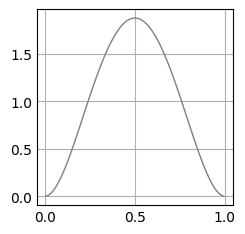

In [125]:
@F
def plotBeta( alphaS, alphaO ):
    Xs = mk01fence( 100 )
    Betas = [
        scipy.stats.beta.pdf( x, alphaS, alphaO )
        for x in Xs
    ]
    ##
    plt.style.use('_mpl-gallery')
    # plot
    fig, ax = plt.subplots()
    ax.plot( Xs, Betas, linewidth=1.0, color="grey" )
    ## 
    plt.show()

plotBeta( 3,3 )

In [133]:
Distros = [
    i
    for i in DistrosSQ
    if i[1] == 0.675
]
pprint(Distros)

[[0.025, 0.675, {'Covert': 0.0, 'None': 0.065, 'Overt': 0.935}],
 [0.075, 0.675, {'Covert': 0.0, 'None': 0.07, 'Overt': 0.93}],
 [0.125, 0.675, {'Covert': 0.0, 'None': 0.06, 'Overt': 0.94}],
 [0.175, 0.675, {'Covert': 0.0, 'None': 0.08, 'Overt': 0.92}],
 [0.225, 0.675, {'Covert': 0.0, 'None': 0.08, 'Overt': 0.92}],
 [0.275, 0.675, {'Covert': 0.0, 'None': 0.08, 'Overt': 0.92}],
 [0.325, 0.675, {'Covert': 0.0, 'None': 0.075, 'Overt': 0.925}],
 [0.375, 0.675, {'Covert': 0.0, 'None': 0.115, 'Overt': 0.885}],
 [0.425, 0.675, {'Covert': 0.0, 'None': 0.1, 'Overt': 0.9}],
 [0.475, 0.675, {'Covert': 0.0, 'None': 0.2, 'Overt': 0.8}],
 [0.525, 0.675, {'Covert': 0.0, 'None': 0.34, 'Overt': 0.66}],
 [0.575, 0.675, {'Covert': 0.0, 'None': 0.58, 'Overt': 0.42}],
 [0.625, 0.675, {'Covert': 0.0, 'None': 0.995, 'Overt': 0.005}],
 [0.675, 0.675, {'Covert': 0.0, 'None': 1.0, 'Overt': 0.0}],
 [0.725, 0.675, {'Covert': 0.0, 'None': 1.0, 'Overt': 0.0}],
 [0.775, 0.675, {'Covert': 0.0, 'None': 1.0, 'Overt': 0

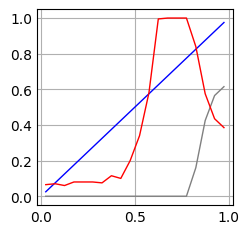

In [134]:
def plotDistros( distros ):
    Xs = get(0).map()( distros )
    Cs = ( get(2) | get("Covert") ).map()( distros )
    Os = ( get(2) | get("Overt") ).map()( distros )
    Ns = ( get(2) | get("None") ).map()( distros )
    ##
    plt.style.use('_mpl-gallery')
    # plot
    fig, ax = plt.subplots()
    ax.plot( Xs,Xs, linewidth=1.0, color="blue" )
    ax.plot( Xs,Cs, linewidth=1.0, color="grey" )
    ## ax.plot( Xs,Os, linewidth=1.0, color="green" )
    ax.plot( Xs,Ns, linewidth=1.0, color="red" )
    ##
    ## 
    plt.show()

plotDistros( Distros )

In [123]:
pprint( [ l for l in Distros if l[0] == 0.4975  ] )

[[0.4975, 0.3325, {'Covert': 0.505, 'None': 0.0, 'Overt': 0.495}]]


In [ ]:
## Fun mkGraph